

# Projeto de Aprendizado de Máquina Aplicado à Robótica
## Equipe: 
- Bruno de Oliveira Pinheiro Júnior (bopj)
- Daniel Victor da Costa Carneiro Salvador (dvccs)
- Estela de Andrade Joffily (eaj2)

> --Esta célula pode ser apagada depois, é apenas para consultar o enunciado--

Item 1. Escolha uma base de dados (por exemplo do repositório UCI) de um problema de classificação ou regressão. Apresente o problema de forma suscinta, com suas variáveis
preditoras e alvo.

Item 2. Aplique o algoritmo de árvores de decisão e inspecione o conhecimento adquirido. Vc pode por exemplo selecionar a partir da árvore construída, regras com boa cobertura e confiança e discuti-las.

Item 3. Realize experimentos com algoritmos diversos e selecione o melhor algoritmo com base em uma métrica de avaliação de interesse. Justifique a escolha da métrica. Dependendo do algoritmo, faça experimentos com variação de parâmetros (e.g., valor do parâmetro k, do algoritmo kNN).

Item 4. Escolha um ou mais algoritmos de classificação (por exemplo, IBk) e use técnicas de seleção de atributos para identificar as variáveis consideradas mais relevantes para o problema de classificação escolhido. Analise o impacto da seleção de atributos, avaliando o algoritmo escolhido usando (a) todos os atributos do problema, ou seja, sem seleção (b) e apenas usando os atributos selecionados.

Item 5. Selecione o melhor modelo encontrado no item anterior e aplique pelo menos duas técnicas de interpretabilidade, como:

* Feature importante: discuta que características foram mais importantes para o modelo;

* Global surrogate: apresente o modelo interpretável gerado e discuta os insights observados com o modelo;  

* Local surrogate: apresente pelo menos dois exemplos a serem explicados e gere as explicações com o LIME;

* PDP: faça pelos menos três gráficos PDP, variando os atributos analisados e discuta os resultados; ou outras técnicas de interesse.

Discuta os insights e conclusões sobre a aplicação das técnicas de interpretabilidade aplicadas.

A célula abaixo realizará os imports necessários para a execução deste notebook. Os modelos utilizados serão do Scikit Learn enquanto que usaremos principalmente o Seaborn para plotar gráficos e as estatísticas necessárias. O pandas será usado para manipular o dataframe.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report


### Apresentação do *dataset* e preparação inicial

O [Stellar Classification Dataset - SDSS17](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17?resource=download) é uma base de dados que classifica objetos estelares com base em suas características espectrais. Este *dataset* contém 100.000 instâncias classificadas dentre estrelas, galáxias e quasares, provenientes de observações do SDSS (**Sloan Digital Sky Survey**). Cada instância tem 17 atributos e a coluna `class` que se refere à classe:

- `obj_ID` = **Object Identifier**, valor único que identifica o objeto no catálogo de imagens usado pelo CAS
- `alpha` = Ângulo de ascensão reto (à época J2000)
- `delta` = Ângulo de declinação (à época J2000)
- `u` = Filtro ultravioleta no sistema fotométrico
- `g` = Filtro verde no sistema fotométrico
- `r` = Filtro vermelho no sistema fotométrico
- `i` = Filtro infravermelho próximo no sistema fotométrico
- `z` = Filtro infravermelho no sistema fotométrico
- `run_ID` = Número de execução usado para identificar a varredura específica
- `rereun_ID` = Número de repetição da execução para especificar como a imagem foi processada
- `cam_col` = Coluna da câmera para identificar a linha de varredura dentro da execução
- `field_ID` = Número do campo para identificar cada campo
- `spec_obj_ID` = ID única utilizada por objetos espectroscópicos ópticos (2 observações diferentes com o mesmo `spec_obj_ID must` são da mesma classe)
- `class` = classe do objeto ('galaxy', 'star' ou 'quasar')
- `redshift` = Valor do desvio para vermelho com base no aumento do comprimento de onda
- `plate` = ID da placa, identifica cada placa no SDSS
- `MJD` = Data Juliana Modificada, usada para indicar quando um dado do SDSS foi obtido
- `fiber_ID` = ID da fibra, identifica a fibra que apontou a luz para o plano focal em cada observação

In [3]:
data = pd.read_csv('star_classification.csv')
data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


A célula abaixo vai remover do dataframe colunas que identificavam, não o objeto astronômico, mas sim seu processo de detecção, sendo irrelevante para a predição que vamos realizar. Além disso, vamos construir o array X de atributos e o array y com os alvos para nossos modelos:

In [4]:
# Limpando o dataframe
id_columns = ['obj_ID', 'run_ID', 'rerun_ID', 'cam_col',
              'field_ID', 'spec_obj_ID', 'plate', 'MJD',
              'fiber_ID']
df = data.drop(columns=id_columns, axis=1)

# Alvos e atributos
y = df['class']
X = df.drop(columns=['class'], axis=1)

X=(X-X.mean())/X.std()

# Formato das matrizes e proporção entre as classes
X.shape, y.shape
print(f"Shape of X: {X.shape}\nShape of Y: {y.shape}")
df['class'].value_counts(normalize=True)

Shape of X: (100000, 8)
Shape of Y: (100000,)


class
GALAXY    0.59445
STAR      0.21594
QSO       0.18961
Name: proportion, dtype: float64

Vamos realizar a divisão do dataset em treino e teste, numa proporção de 80% para treino e 20% para teste:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Antes de começarmos o treinamento dos modelos, vamos criar uma função para receber um vetor com as predições dos modelos e um vetor com os alvos, para recebermos um relatório com algumas métricas que indicarão o desempenho do algoritmo, a saber: 
- Acurácia:
- Precisão:
- Recall:
- F-score:
- Suporte:

Além disso veremos também a matriz de confusão:

In [6]:
def model_report(y_test, y_pred):
    """Shows a report on a given model, containing various metrics

    Args:
        y_test (array): Test targets
        y_pred (array): Test predictions
    """
    acc = accuracy_score(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred, normalize='true')
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

    report = (f'Accuracy: {acc:.2f}\n'
              f'Precision: {[round(x,2) for x in precision]}\n'
              f'Recall: {[round(x,2) for x in recall]}\n'
              f'F-Score: {[round(x,2) for x in fscore]}\n'
              f'Support: {[round(x,2) for x in support]}\n')

    sns.heatmap(matrix, annot=True)
    plt.title(report)
    plt.show()


### Aplicando um algoritmo de árvore de decisão

Vamos começar com modelos de árvores de decisão, criando uma função para treinar várias variando o parâmetro de profundidade da árvore:

In [7]:
def decision_tree_classifier_evaluate_depth(
        x_y_dataframe: tuple,
        min_depth: int,
        max_depth: int,
        min_samples_leaf: int = 1,
):
    """Function to evaluate the Decision Tree Classifier with different depths.

    Args:
        x_y_dataframe (tuple): A tuple containing the dataframe split into
            X and y, where y is a pandas.Series containing the labels.
        min_depth (int): The range minimum depth
        max_depth (int): The range maximum depth
        min_samples_leaf (int, optional): Defaults to 1.
    """
    X, y = x_y_dataframe

    for i in range(min_depth, max_depth+1):
        model = DecisionTreeClassifier(
            criterion='entropy',
            max_depth=i,
            random_state=42,
            min_samples_leaf=min_samples_leaf,
            ccp_alpha=0.0
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print(f'Tree max depth: {i}')
        model_report(y_test, y_pred)


Aplicando o algoritmo:

Tree max depth: 2


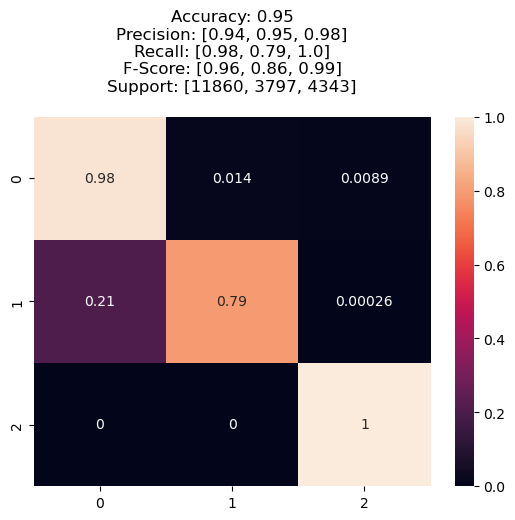

Tree max depth: 3


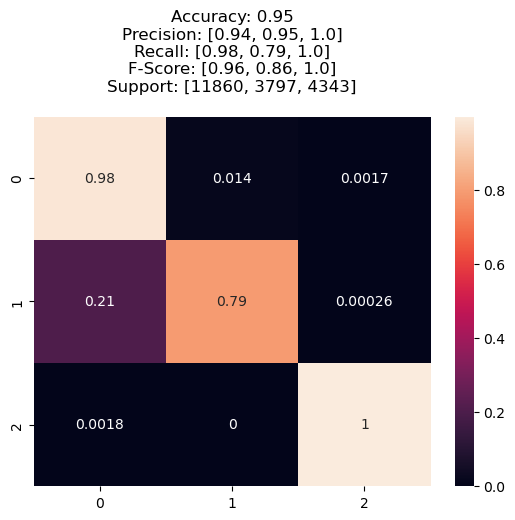

Tree max depth: 4


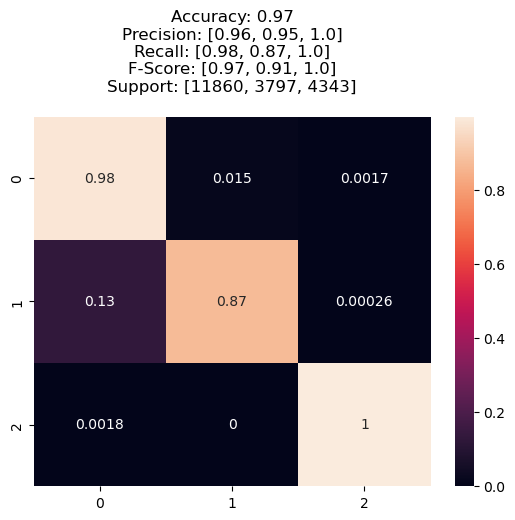

Tree max depth: 5


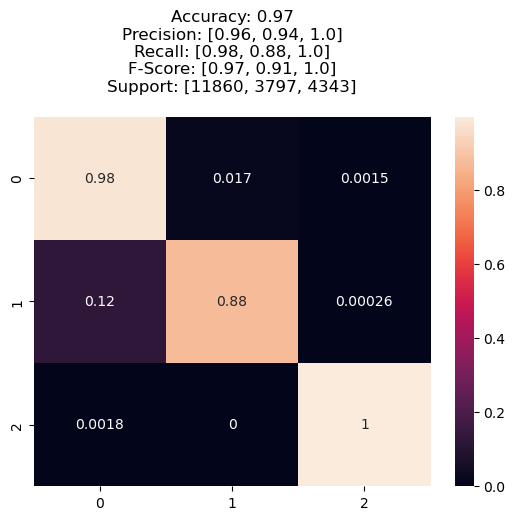

In [8]:
decision_tree_classifier_evaluate_depth(
    x_y_dataframe=(X, y),
    min_depth=2,
    max_depth=5,
)

A árvore com profundidade máxima 4 apresentou as melhores métricas. Vamos instânciá-la novamente e mostrar sua estrutura:

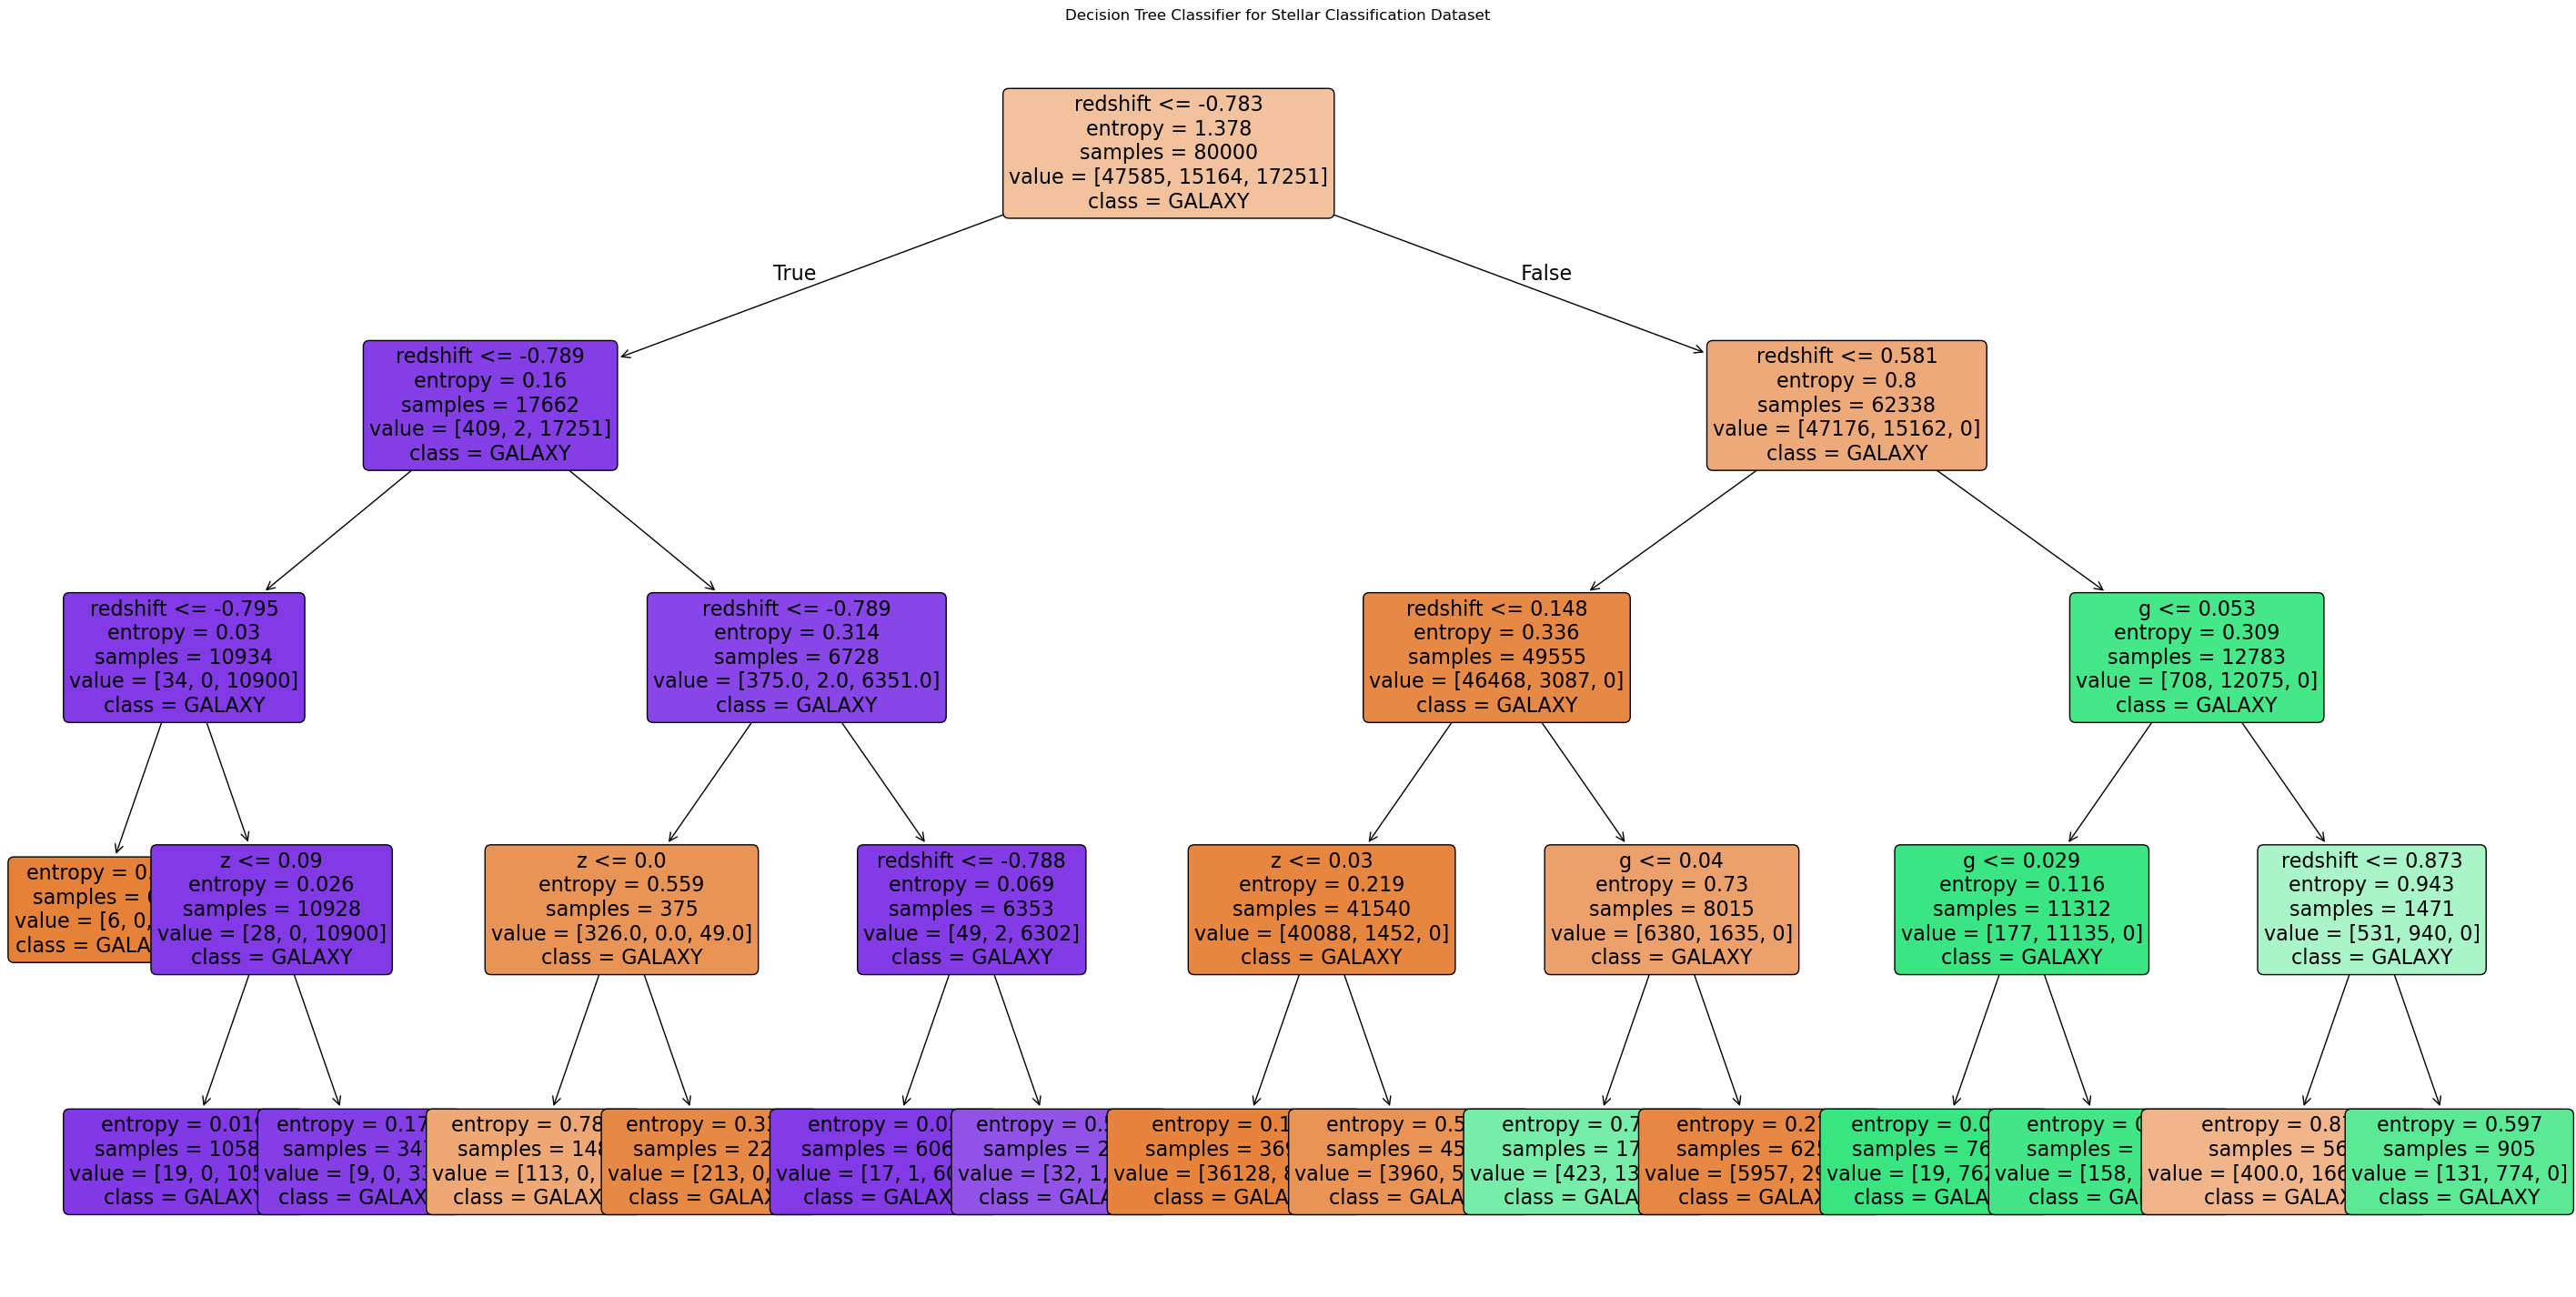

In [59]:
model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=4,
    min_samples_leaf=1,
    random_state=42,
    ccp_alpha=0.0
)

model.fit(X_train, y_train)

plt.figure(figsize=(36, 18))
plot_tree(
    model,
    feature_names=X.columns.to_list(),
    class_names=y.values.tolist(),
    rounded=True,
    filled=True,
    fontsize=16,
)
plt.title('Decision Tree Classifier for Stellar Classification Dataset')
plt.show()

### Análise das regras

blah blah

### Treinando com SVM

Os parâmetros `C` e `gamma` são variados e o modelo é avaliado em relação à curva ROC e a AUC e à curva de precisão-recall.

- Parâmetro `C`: responsável pela regularização. Um `C` maior permite mais erros de classificação, o que generaliza melhor o modelo e diminui a possibilidade de *overfitting*. Um `C` menor penaliza mais os erros de classificação, criando uma separação de classes mais precisa, porém pode levar ao *overfitting*.
- Parâmetro `gamma`: define como cada ponto de amostra influencia o limite de decisão, afetando sua distância de influência. Um `gamma` baixo faz com que pontos distantes do limite de decisão tenham uma influência maior, levando a um modelo mais suave. Um `gamma` alto aumenta a influência dos pontos próximos ao limite de decisão, o que pode resultar em *overfitting*.

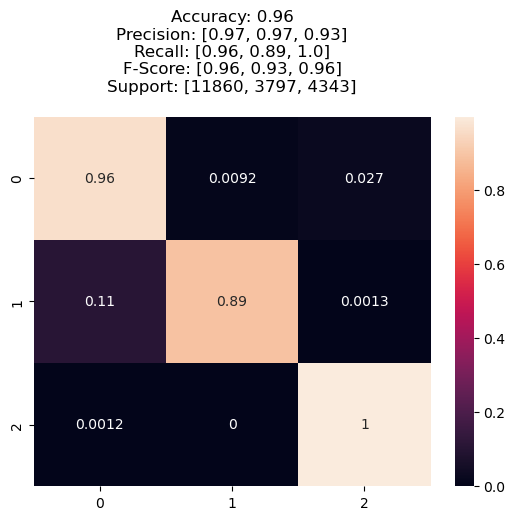

In [9]:
svm = SVC(kernel='rbf', C=1, gamma=0.1, random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
model_report(y_test, y_pred)

### Treinando com algoritmo Ingênuo de Bayes Gaussiano

### Treinando com -algoritmo 3-

### Treinando com Perceptron Multi-Camadas (MLP)


c:\Users\dvccs\AppData\Local\miniconda3\envs\ml-proj-rria\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


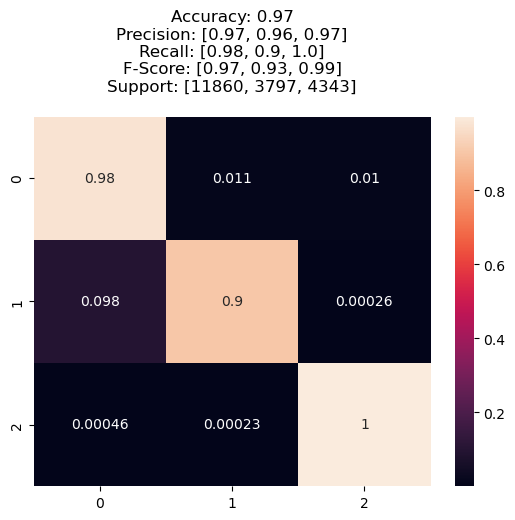

In [62]:
neural_network = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(6,), random_state=1)
neural_network.fit(X_train, y_train)
y_pred = neural_network.predict(X_test)
model_report(y_test, y_pred)